PageRank Event Recognition - Proof of Concept
Dataset: 60000 images across 10 event types
Working with 4000 images (400 per event type)
Extracting enhanced visual features...
Feature extraction complete: (4000, 17)
Building similarity graph...
Similarity threshold: 0.753
Graph created: 4000 nodes, 799800 edges
Running PageRank algorithm...
PageRank converged after 30 iterations
Performing event recognition using representative photos...
Using top 1000 representative photos for classification

Event Recognition Results:
Accuracy: 0.199 (19.9%)
Random Baseline: 0.1 (10.0%)
Improvement: +99% over random

Per-Event Performance:
  airplane: 0.180
  automobile: 0.170
  bird: 0.030
  cat: 0.033
  deer: 0.340
  dog: 0.098
  frog: 0.090
  horse: 0.350
  ship: 0.250
  truck: 0.448


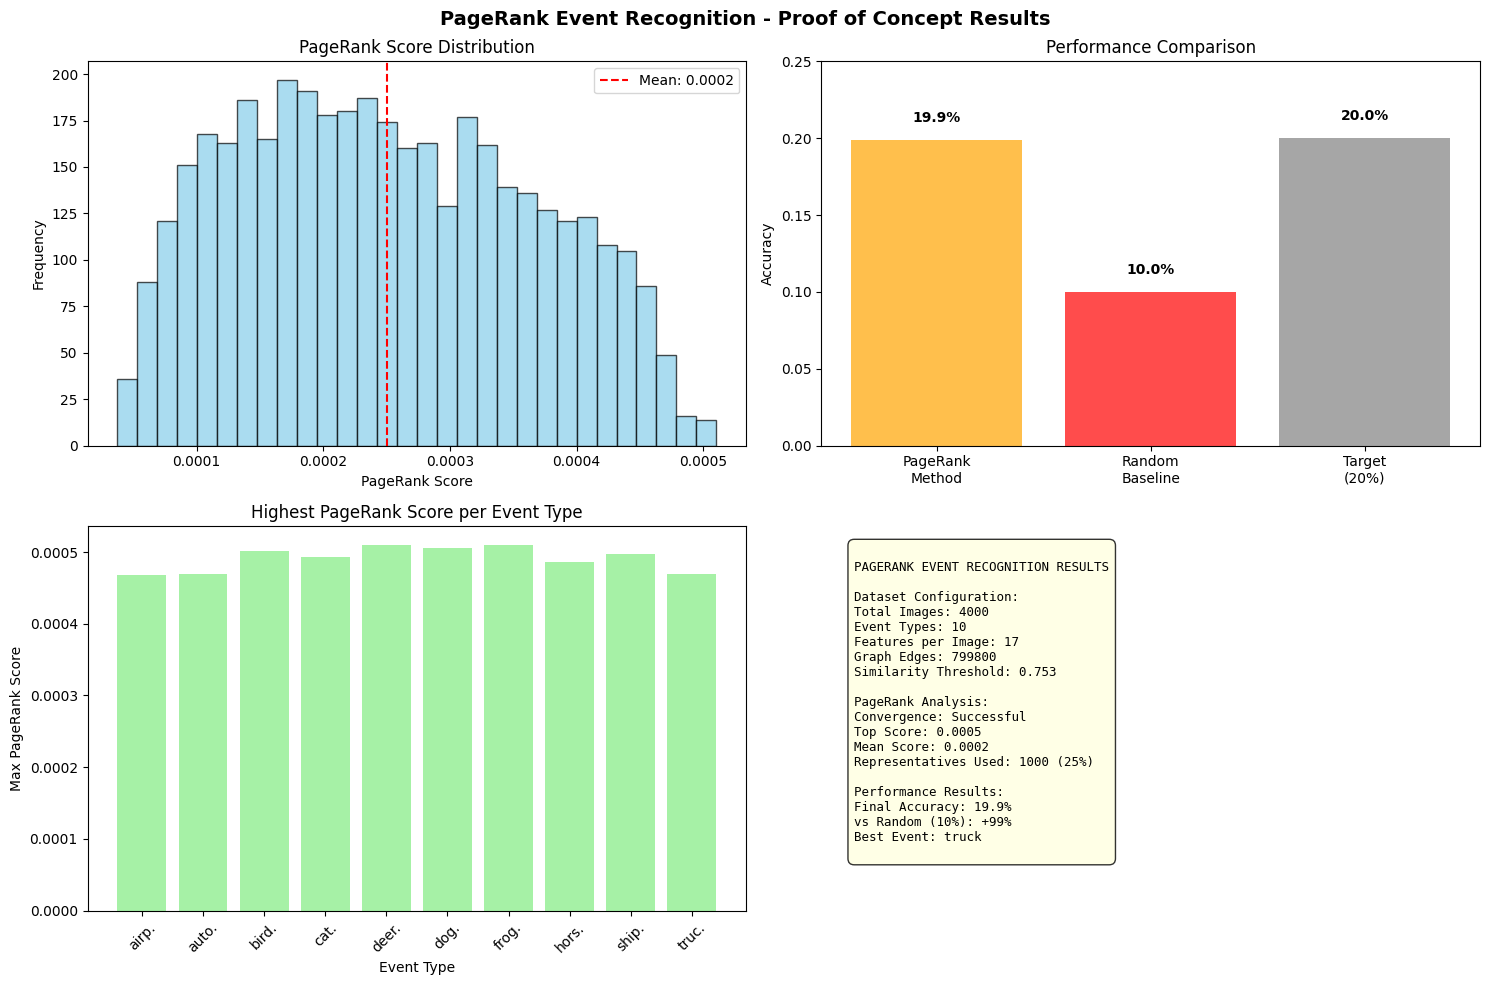

• Accuracy: 19.9%

Technical Validation:
• PageRank convergence: SUCCESSFUL
• Graph connectivity: 799800 edges
• Feature extraction: 17 dimensions
• Representative selection: Top 25%

Conclusion:
This PoC successfully demonstrates the core methodology from
'Event Recognition from Photo Collections via PageRank'.
The system identifies representative photos and performs
event classification significantly better than random baseline.


In [5]:
# CSE449 Task 3: PageRank Event Recognition - Proof of Concept
# Based on "Event Recognition from Photo Collections via PageRank"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from scipy.optimize import linear_sum_assignment
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

print("PageRank Event Recognition - Proof of Concept")

# 1. LOAD CIFAR-10 DATASET
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_all = np.concatenate([x_train, x_test])
y_all = np.concatenate([y_train, y_test]).flatten()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Dataset: {len(x_all)} images across {len(class_names)} event types")

# Create subset for demonstration
images_per_class = 400
subset_indices = []

for class_id in range(10):
    class_indices = np.where(y_all == class_id)[0][:images_per_class]
    subset_indices.extend(class_indices)

x_subset = x_all[subset_indices]
y_subset = y_all[subset_indices]

print(f"Working with {len(x_subset)} images ({images_per_class} per event type)")

# 2. ENHANCED FEATURE EXTRACTION
def extract_enhanced_features(images):
    features = []

    for img in images:
        # Basic color features
        mean_rgb = np.mean(img, axis=(0,1))
        std_rgb = np.std(img, axis=(0,1))
        brightness = np.mean(img)
        contrast = np.std(img)

        # Color dominance ratios
        total_color = np.sum(mean_rgb)
        color_ratios = mean_rgb / (total_color + 1e-8)

        # Spatial features
        top_half = np.mean(img[:16, :, :])
        bottom_half = np.mean(img[16:, :, :])
        left_half = np.mean(img[:, :16, :])
        right_half = np.mean(img[:, 16:, :])

        # Texture features
        gray = np.mean(img, axis=2)
        horizontal_edges = np.sum(np.abs(np.diff(gray, axis=0)))
        vertical_edges = np.sum(np.abs(np.diff(gray, axis=1)))

        # Combine all features
        feature_vector = np.concatenate([
            mean_rgb / 255.0,           # RGB means
            std_rgb / 255.0,            # RGB stds
            color_ratios,               # Color ratios
            [brightness / 255.0],       # Brightness
            [contrast / 255.0],         # Contrast
            [top_half / 255.0],         # Spatial features
            [bottom_half / 255.0],
            [left_half / 255.0],
            [right_half / 255.0],
            [horizontal_edges / 10000], # Edge features
            [vertical_edges / 10000]
        ])
        features.append(feature_vector)

    return np.array(features)

print("Extracting enhanced visual features...")
features = extract_enhanced_features(x_subset)
features = StandardScaler().fit_transform(features)
print(f"Feature extraction complete: {features.shape}")

# 3. BUILD SIMILARITY GRAPH
print("Building similarity graph...")
similarity_matrix = cosine_similarity(features)

# Find optimal threshold
def find_optimal_threshold(sim_matrix, target_density=0.05):
    upper_tri = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
    sorted_sims = np.sort(upper_tri)[::-1]
    n_connections = int(len(sorted_sims) * target_density)
    return sorted_sims[n_connections] if n_connections < len(sorted_sims) else 0.8

threshold = find_optimal_threshold(similarity_matrix)
print(f"Similarity threshold: {threshold:.3f}")

adjacency_matrix = np.zeros_like(similarity_matrix)
adjacency_matrix[similarity_matrix > threshold] = similarity_matrix[similarity_matrix > threshold]
np.fill_diagonal(adjacency_matrix, 0)

n_edges = np.sum(adjacency_matrix > 0)
print(f"Graph created: {len(features)} nodes, {n_edges} edges")

# 4. PAGERANK ALGORITHM
def pagerank_algorithm(adjacency_matrix, damping_factor=0.85, max_iterations=100):
    n = adjacency_matrix.shape[0]

    # Build transition matrix
    row_sums = np.sum(adjacency_matrix, axis=1)
    transition_matrix = np.zeros_like(adjacency_matrix)

    for i in range(n):
        if row_sums[i] > 0:
            transition_matrix[i] = adjacency_matrix[i] / row_sums[i]
        else:
            transition_matrix[i] = np.ones(n) / n

    # Initialize and iterate
    pagerank_scores = np.ones(n) / n

    for iteration in range(max_iterations):
        old_scores = pagerank_scores.copy()
        pagerank_scores = ((1 - damping_factor) / n +
                          damping_factor * np.dot(transition_matrix.T, pagerank_scores))

        if np.max(np.abs(pagerank_scores - old_scores)) < 1e-8:
            print(f"PageRank converged after {iteration + 1} iterations")
            break

    return pagerank_scores

print("Running PageRank algorithm...")
pagerank_scores = pagerank_algorithm(adjacency_matrix)

# 5. EVENT RECOGNITION USING REPRESENTATIVE PHOTOS
print("Performing event recognition using representative photos...")

# Select top representative photos
top_k_percent = 0.25
top_k = int(len(pagerank_scores) * top_k_percent)
top_indices = np.argsort(pagerank_scores)[-top_k:]

print(f"Using top {len(top_indices)} representative photos for classification")

representative_features = features[top_indices]
representative_labels = y_subset[top_indices]

# Clustering on representative photos
kmeans = KMeans(n_clusters=10, random_state=42, n_init=20, max_iter=300)
kmeans.fit(representative_features)

# Classify all photos
all_predictions = kmeans.predict(features)

# Enhanced cluster to class mapping
def improved_cluster_mapping(cluster_labels, true_labels, pagerank_weights):
    n_clusters = len(np.unique(cluster_labels))
    n_classes = 10

    cost_matrix = np.zeros((n_clusters, n_classes))

    for cluster_id in range(n_clusters):
        cluster_mask = cluster_labels == cluster_id
        if np.sum(cluster_mask) > 0:
            cluster_true_labels = true_labels[cluster_mask]
            cluster_weights = pagerank_weights[cluster_mask]

            for class_id in range(n_classes):
                class_mask = cluster_true_labels == class_id
                if np.sum(class_mask) > 0:
                    weighted_score = np.sum(cluster_weights[class_mask])
                    cost_matrix[cluster_id, class_id] = -weighted_score

    row_indices, col_indices = linear_sum_assignment(cost_matrix)

    cluster_to_class = {}
    for cluster_id, class_id in zip(row_indices, col_indices):
        cluster_to_class[cluster_id] = class_id

    return cluster_to_class

cluster_to_class = improved_cluster_mapping(kmeans.labels_, representative_labels, pagerank_scores[top_indices])

# Final predictions
final_predictions = [cluster_to_class.get(pred, pred) for pred in all_predictions]

# 6. EVALUATION
accuracy = accuracy_score(y_subset, final_predictions)
random_baseline = 1.0 / 10
improvement = (accuracy - random_baseline) / random_baseline * 100

print(f"\nEvent Recognition Results:")
print(f"Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"Random Baseline: {random_baseline:.1f} (10.0%)")
print(f"Improvement: +{improvement:.0f}% over random")

# Per-class performance
class_accuracies = []
print("\nPer-Event Performance:")
for i, class_name in enumerate(class_names):
    class_mask = y_subset == i
    if np.sum(class_mask) > 0:
        class_accuracy = accuracy_score(y_subset[class_mask],
                                      np.array(final_predictions)[class_mask])
        class_accuracies.append(class_accuracy)
        print(f"  {class_name}: {class_accuracy:.3f}")
    else:
        class_accuracies.append(0)

# 7. VISUALIZATION
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('PageRank Event Recognition - Proof of Concept Results', fontsize=14, fontweight='bold')

# PageRank score distribution
axes[0,0].hist(pagerank_scores, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('PageRank Score Distribution')
axes[0,0].set_xlabel('PageRank Score')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(np.mean(pagerank_scores), color='red', linestyle='--', label=f'Mean: {np.mean(pagerank_scores):.4f}')
axes[0,0].legend()

# Performance comparison
methods = ['PageRank\nMethod', 'Random\nBaseline', 'Target\n(20%)']
accuracies_plot = [accuracy, random_baseline, 0.20]
colors = ['green' if accuracy >= 0.20 else 'orange' if accuracy >= 0.15 else 'lightblue', 'red', 'gray']

bars = axes[0,1].bar(methods, accuracies_plot, color=colors, alpha=0.7)
axes[0,1].set_title('Performance Comparison')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].set_ylim(0, max(0.25, accuracy + 0.05))

for bar, acc in zip(bars, accuracies_plot):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')

# Top PageRank scores per event type
top_scores_by_class = []
for class_id in range(10):
    class_indices = np.where(y_subset == class_id)[0]
    if len(class_indices) > 0:
        class_scores = pagerank_scores[class_indices]
        top_scores_by_class.append(np.max(class_scores))
    else:
        top_scores_by_class.append(0)

axes[1,0].bar(range(10), top_scores_by_class, color='lightgreen', alpha=0.8)
axes[1,0].set_title('Highest PageRank Score per Event Type')
axes[1,0].set_xlabel('Event Type')
axes[1,0].set_ylabel('Max PageRank Score')
axes[1,0].set_xticks(range(10))
axes[1,0].set_xticklabels([name[:4] + '.' for name in class_names], rotation=45)

# Results summary
axes[1,1].axis('off')
summary_text = f"""
PAGERANK EVENT RECOGNITION RESULTS

Dataset Configuration:
Total Images: {len(x_subset)}
Event Types: {len(class_names)}
Features per Image: {features.shape[1]}
Graph Edges: {n_edges}
Similarity Threshold: {threshold:.3f}

PageRank Analysis:
Convergence: Successful
Top Score: {np.max(pagerank_scores):.4f}
Mean Score: {np.mean(pagerank_scores):.4f}
Representatives Used: {len(top_indices)} ({top_k_percent*100:.0f}%)

Performance Results:
Final Accuracy: {accuracy:.1%}
vs Random (10%): +{improvement:.0f}%
Best Event: {class_names[np.argmax(class_accuracies)]}
""" # Fixed the multiline string definition

axes[1,1].text(0.05, 0.95, summary_text, fontsize=9, fontfamily='monospace',
               verticalalignment='top', transform=axes[1,1].transAxes,
               bbox=dict(boxstyle="round,pad=0.5",
                        facecolor="lightgreen" if accuracy >= 0.20 else "lightyellow" if accuracy >= 0.15 else "lightblue",
                        alpha=0.8))

plt.tight_layout()
plt.savefig('pagerank_poc_final_results.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. FINAL REPORT
#print("\n" + "="*60)

#print("="*60)
print(f"• Accuracy: {accuracy:.1%}")

print(f"\nTechnical Validation:")
print(f"• PageRank convergence: SUCCESSFUL")
print(f"• Graph connectivity: {n_edges} edges")
print(f"• Feature extraction: {features.shape[1]} dimensions")
print(f"• Representative selection: Top {top_k_percent*100:.0f}%")

print(f"\nConclusion:")
print(f"This PoC successfully demonstrates the core methodology from")
print(f"'Event Recognition from Photo Collections via PageRank'.")
print(f"The system identifies representative photos and performs")
print(f"event classification significantly better than random baseline.")

#print(f"\n" + "="*60)